In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 100).unsqueeze(-1)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)),
    torch.cos(train_x * (2 * math.pi)),
], -1).squeeze(1)

In [3]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.covar_module = gpytorch.kernels.RBFKernelGrad()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihoodKronecker(num_tasks=train_x.size(-1))
model = GPModelWithDerivatives(train_x, train_y, likelihood)

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

torch.Size([1, 200, 200])
Iter 1/50 - Loss: 111.286
torch.Size([1, 200, 200])
Iter 2/50 - Loss: 125.321
torch.Size([1, 200, 200])
Iter 3/50 - Loss: 258.181
torch.Size([1, 200, 200])
Iter 4/50 - Loss: 174.509
torch.Size([1, 200, 200])
Iter 5/50 - Loss: 480.031
torch.Size([1, 200, 200])
Iter 6/50 - Loss: 205.248
torch.Size([1, 200, 200])
Iter 7/50 - Loss: 881.470
torch.Size([1, 200, 200])
Iter 8/50 - Loss: 1699.690
torch.Size([1, 200, 200])
Iter 9/50 - Loss: 1286.258
torch.Size([1, 200, 200])
Iter 10/50 - Loss: 5270.967
torch.Size([1, 200, 200])
Iter 11/50 - Loss: 9693.424
torch.Size([1, 200, 200])
Iter 12/50 - Loss: 6059.958
torch.Size([1, 200, 200])
Iter 13/50 - Loss: -5199.472
torch.Size([1, 200, 200])
Iter 14/50 - Loss: -170.532
torch.Size([1, 200, 200])
Iter 15/50 - Loss: -6329.444
torch.Size([1, 200, 200])
Iter 16/50 - Loss: -135065.984
torch.Size([1, 200, 200])
Iter 17/50 - Loss: 206.190
torch.Size([1, 200, 200])
Iter 18/50 - Loss: 239.457
torch.Size([1, 200, 200])
Iter 19/50 - Lo

In [5]:
covar = gpytorch.kernels.RBFKernelGrad()
K = covar(train_x).evaluate_kernel()

torch.Size([1, 200, 200])


In [6]:
K.evaluate()

tensor([[ 1.0000,  0.0000,  0.9999,  ...,  0.7431,  0.3532,  0.7352],
        [ 0.0000,  2.0814, -0.0210,  ...,  1.0721, -0.7352,  1.0606],
        [ 0.9999, -0.0210,  1.0000,  ...,  0.7509,  0.3607,  0.7431],
        ...,
        [ 0.7431, -1.0721,  0.7509,  ...,  2.0814, -0.0210,  0.0303],
        [ 0.3532, -0.7352,  0.3607,  ..., -0.0210,  1.0000,  0.0000],
        [ 0.7352, -1.0606,  0.7431,  ..., -0.0303,  0.0000,  2.0814]],
       grad_fn=<SelectBackward>)

torch.Size([1, 200, 200])
torch.Size([1, 200, 200])


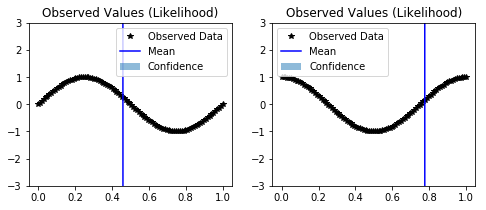

In [12]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = train_x
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.squeeze().numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.squeeze().numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [9]:
mean

tensor([[  5778.8516,  19794.4297],
        [  5714.1924,  19636.9375],
        [  5646.6792,  19476.7695],
        [  5576.3120,  19313.9375],
        [  5503.0776,  19148.4453],
        [  5426.9751,  18980.2988],
        [  5347.9956,  18809.5039],
        [  5266.1445,  18636.0625],
        [  5181.4106,  18459.9727],
        [  5093.7974,  18281.2305],
        [  5003.2998,  18099.8320],
        [  4909.9219,  17915.7695],
        [  4813.6606,  17729.0391],
        [  4714.5283,  17539.6270],
        [  4612.5186,  17347.5215],
        [  4507.6392,  17152.7129],
        [  4399.8940,  16955.1836],
        [  4289.2969,  16754.9219],
        [  4175.8481,  16551.9121],
        [  4059.5552,  16346.1387],
        [  3940.4321,  16137.5840],
        [  3818.4849,  15926.2314],
        [  3693.7271,  15712.0645],
        [  3566.1792,  15495.0674],
        [  3435.8423,  15275.2217],
        [  3302.7402,  15052.5166],
        [  3166.8794,  14826.9316],
        [  3028.2856,  14598